In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import json
import lmfit
from sklearn.cluster import KMeans
path = "./data/pi0.csv"
cali_result = "./data/cali_result.json"

def pi_mass(e1,p1,e2,p2):
    p0 = np.array([0,0,-500],dtype=np.float64)
    p1,p2 = np.append(p1,[0]), np.append(p2,[0])
    p1,p2 = p1-p0, p2-p0
    cos = np.dot(p1,p2)/(np.linalg.norm(p1)*np.linalg.norm(p2))
    mass = np.sqrt(2*e1*e2*(1-cos))
    return mass
def enr_rebuild():
    with open(cali_result, 'r') as f:
        result = json.load(f)
    return lambda e: e*result['ec']['slope'] + result['ec']['intercept']

def data_filt(mass_all, dis_all):
    # return ykmeans with selected to be 1
    kmeans = KMeans(n_clusters=2,n_init='auto')
    X = np.array([dis_all, mass_all]).T
    kmeans.fit(X)
    ykmeans = kmeans.predict(X)
    # convert dtype to boolean
    ykmeans = ykmeans == 1
    if np.mean(mass_all[ykmeans]) < np.mean(mass_all[~ykmeans]):
        ykmeans = ~ykmeans
    return ykmeans


In [2]:
egap, labs, lgap, lsen, eSen, eAbs = utils.reader_csv(path)
# change unit to GeV
# eSen = enr_rebuild()(eSen*1e-3)
rebuild = enr_rebuild()
num = eSen.shape[0]
data = np.zeros(num, dtype=[('mass', 'f'), ('dis', 'f'), ('label', 'b'),('e1','f'),('e2','f'),('p1','f',(2,)),('p2','f',(2,))])
for i in range(num):
    # shower with max energy
    idx1 = np.argmax(eSen[i])
    energy1, pos1 = utils.get_shower_info(eSen[i], idx_max=idx1)
    # shower with max energy out of shower1
    e = np.copy(eSen[i])
    e[utils.find_shower_pixel(idx1,d=5)] = 0
    idx2 = np.argmax(e)
    del e
    dis = utils.distance(utils.pixel_pos_list()[idx1], utils.pixel_pos_list()[idx2])
    energy2, pos2 = utils.get_shower_info(eSen[i], idx_max=idx2)
    energy1, energy2 = rebuild(energy1*1e-3), rebuild(energy2*1e-3)
    mass = pi_mass(energy1, pos1, energy2, pos2)
    data[i] = (mass, dis, 0, energy1, energy2, pos1, pos2)
    # eSen[i][idx1] = 50
    eSen[i][idx2] = 1e-4

# data = data[data['label']]
mass_all = data['mass']
dis_all = data['dis']
data['label'] = data_filt(data['mass'], data['dis'])
data_raw = np.array([dis_all, mass_all]).T

print(f"num: {num}")
print(f"num mass: {np.shape(mass_all)}")
print(f"num dis: {np.shape(dis_all)}")
print(f"num of mass > 70:{mass_all[mass_all>0.07].shape}")
print(f"num of mass < 70:{mass_all[mass_all<0.07].shape}")
print(f"num of dis > 7:{dis_all[dis_all>7].shape}")
print(f"num of dis < 7:{dis_all[dis_all<7].shape}")
print(f"num of e2 > 1:{(data['e2']>1).sum()}")


num: 5000
num mass: (5000,)
num dis: (5000,)
num of mass > 70:(4181,)
num of mass < 70:(819,)
num of dis > 7:(4573,)
num of dis < 7:(427,)
num of e2 > 1:3965


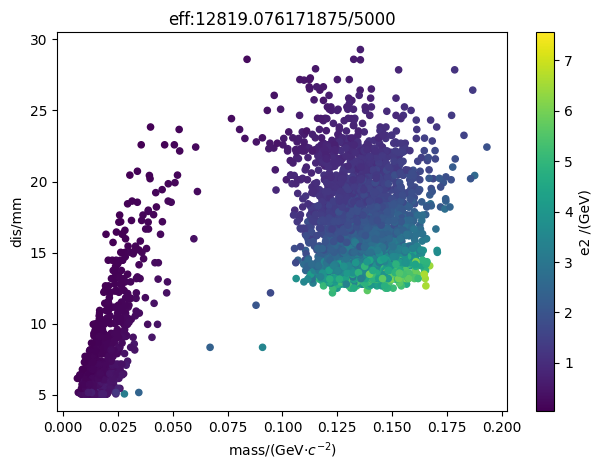

In [3]:
fig,ax = plt.subplots()
c = data['e2']
scatter_plot = ax.scatter(data['mass'], data['dis'], c=c, s=20, cmap='viridis')
# ax.set_title("mass vs dis")
ax.set_xlabel("mass/(GeV$\cdot c^{-2}$)")
ax.set_ylabel("dis/mm")
colorbar = plt.colorbar(scatter_plot, ax=ax)
colorbar.set_label('e2 /(GeV)')
ax.set_title(f'eff:{c.sum()}/5000')
plt.tight_layout()

Text(0.5, 1.0, 'e2')

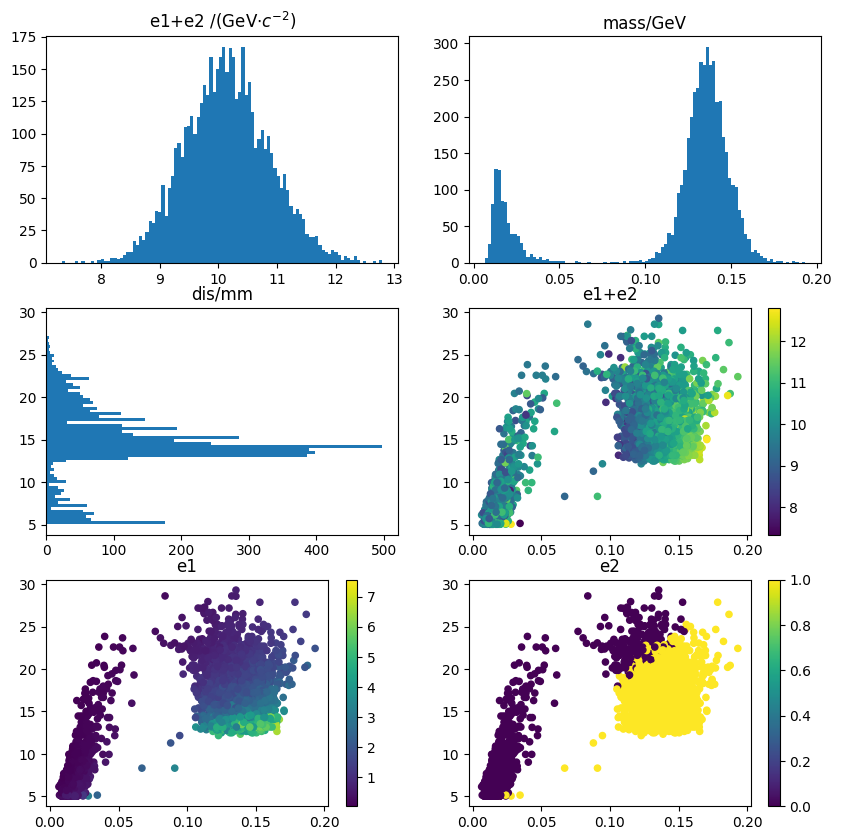

In [4]:
fig,axs = plt.subplots(3,2,figsize=(10,10))
ax = axs[0,1]
ax.hist(data['mass'], bins=100)
ax.set_title("mass/GeV")

ax = axs[1,0]
art = ax.hist(data['dis'],bins=70,orientation=u'horizontal')
ax.set_title("dis/mm")

ax:plt.Axes = axs[0,0]
ax.hist(data['e1']+data['e2'],bins=100)
ax.set_title("e1+e2 /(GeV$\cdot c^{-2}$)")

ax = axs[1,1]
scatter_plot = ax.scatter(data['mass'], data['dis'], c=data['e1']+data['e2'], s=20, cmap='viridis')
plt.colorbar(scatter_plot, ax=ax)
ax.set_title("e1+e2")

ax = axs[2,0]
scatter_plot = ax.scatter(data['mass'], data['dis'], c=data['e2'], s=20, cmap='viridis')
plt.colorbar(scatter_plot, ax=ax)
ax.set_title("e1")
ax = axs[2,1]
scatter_plot = ax.scatter(data['mass'], data['dis'], c=data['e2']>1, s=20, cmap='viridis')
plt.colorbar(scatter_plot, ax=ax)
ax.set_title("e2")
# plt.tight_layout()

In [5]:

idx = data['e2']>1
mass_all = data['mass'][idx]
dis_all = data['dis'][idx]
mass_his, mass_bins = np.histogram(mass_all,bins=50)
mass_bins = 0.5*(mass_bins[1:]+mass_bins[:-1])
mod = lmfit.models.GaussianModel()
par = mod.make_params(amplitude=1, center=0.13, sigma=1)
out = mod.fit(mass_his, par, x=mass_bins)
center, sigma = out.best_values['center'], out.best_values['sigma']
print(out.fit_report())


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 50
    # variables        = 3
    chi-square         = 6362.00476
    reduced chi-square = 135.361803
    Akaike info crit   = 248.303791
    Bayesian info crit = 254.039860
    R-squared          = 0.99423642
[[Variables]]
    amplitude:  13.6464002 +/- 0.16364892 (1.20%) (init = 1)
    center:     0.13637030 +/- 1.4753e-04 (0.11%) (init = 0.13)
    sigma:      0.01065418 +/- 1.4753e-04 (1.38%) (init = 1)
    fwhm:       0.02508867 +/- 3.4741e-04 (1.38%) == '2.3548200*sigma'
    height:     510.985049 +/- 6.12778058 (1.20%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5774


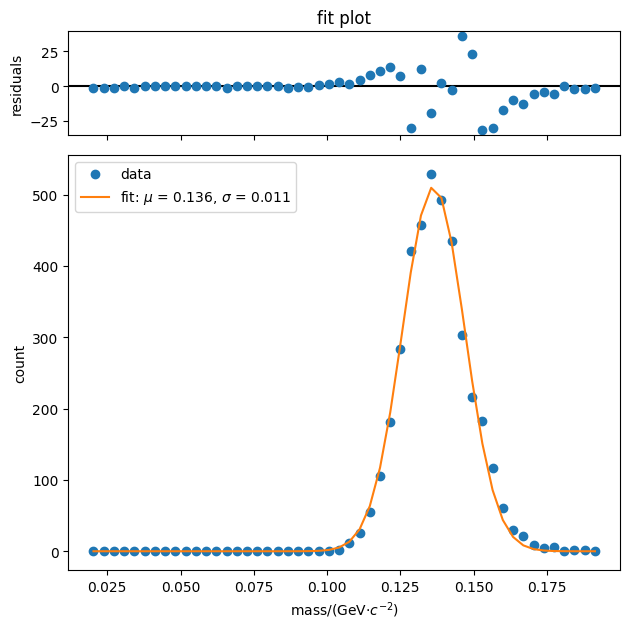

In [6]:

fig = out.plot()
axs = fig.get_axes()
axs[0].set_title("fit plot")
axs[1].set_xlabel("mass/(GeV$\cdot c^{-2}$)")
axs[1].set_ylabel("count")
axs[1].legend(["data", f"fit: $\\mu$ = {center:.3f}, $\\sigma$ = {sigma:.3f}"])
plt.tight_layout()
# plt.savefig("./data/pi0.png")
plt.show()


[0, 1, 2683, 8, 85, 2657]


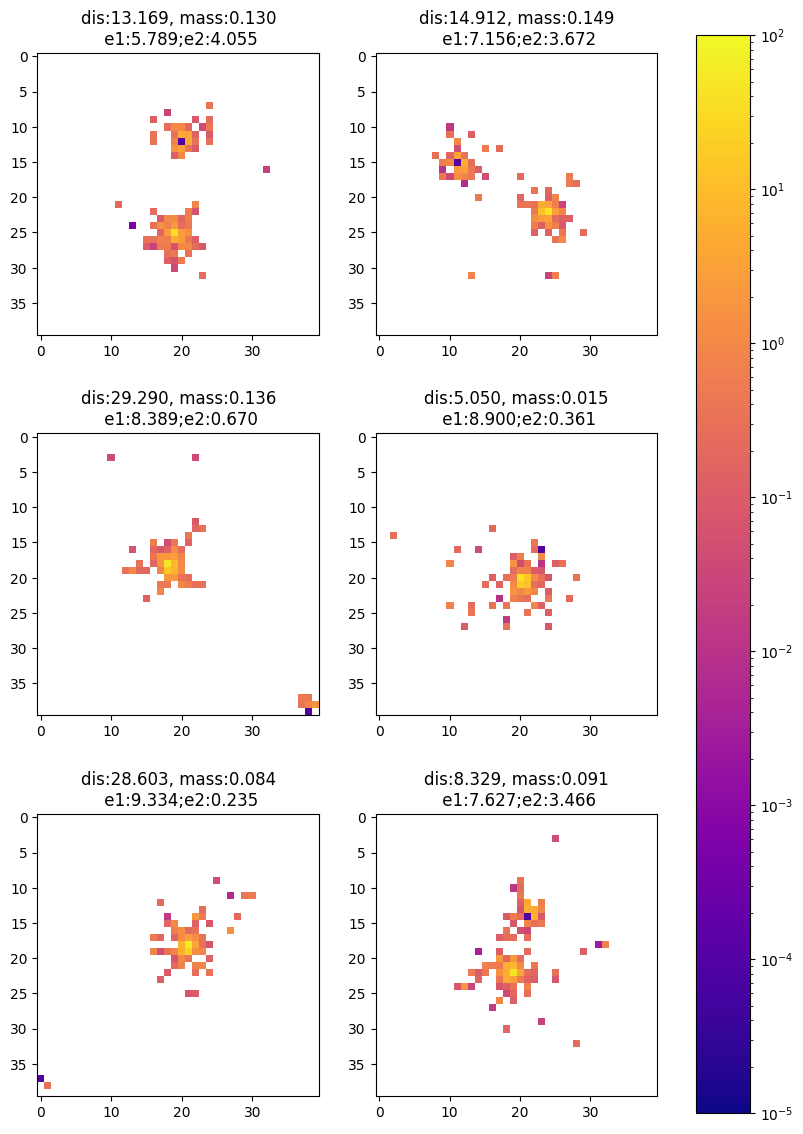

In [7]:
fig,axs = plt.subplots(3,2,figsize=(10,14))
def plot(idx, ax:plt.Axes, **kwargs):
    ax.set_title(f"dis:{data['dis'][idx]:.3f}, mass:{data['mass'][idx]:.3f}\n e1:{data['e1'][idx]:.3f};e2:{data['e2'][idx]:.3f}")
    return utils.edep_plot(eSen[idx], ax, **kwargs)
v = (0, 100)
kwargs = {
    'v':None,
    'norm':LogNorm(1e-5, 1e2)
}
axs = axs.flatten()

idx = [0,1,np.argmax(data['dis']), np.argmin(data['dis'])]
ml7 = np.where((data['mass']>0.07)&(data['mass']<0.1))[0]
idx.append(ml7[np.argmax(data['dis'][ml7])])
idx.append(ml7[np.argmin(data['dis'][ml7])])
for i,ax in zip(idx, axs):
    c = plot(i, ax, **kwargs)
print(idx)
plt.colorbar(c, ax=axs)
# plt.tight_layout()

[0, 1, 2683, 8, 85, 2657]


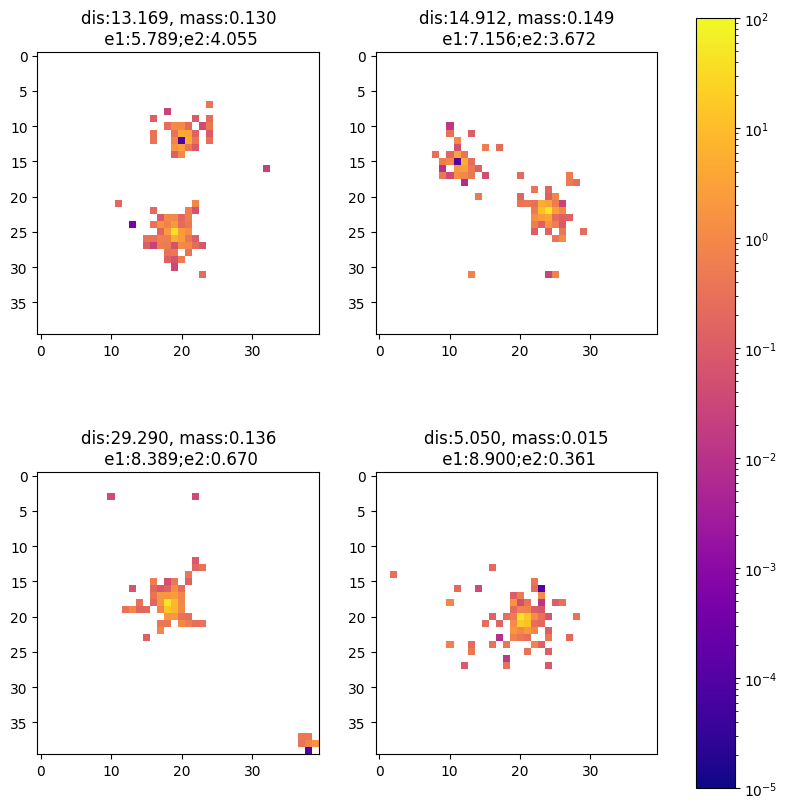

In [8]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
def plot(idx, ax:plt.Axes, **kwargs):
    ax.set_title(f"dis:{data['dis'][idx]:.3f}, mass:{data['mass'][idx]:.3f}\n e1:{data['e1'][idx]:.3f};e2:{data['e2'][idx]:.3f}")
    return utils.edep_plot(eSen[idx], ax, **kwargs)
v = (0, 100)
kwargs = {
    'v':None,
    'norm':LogNorm(1e-5, 1e2)
}
axs = axs.flatten()

idx = [0,1,np.argmax(data['dis']), np.argmin(data['dis'])]
ml7 = np.where((data['mass']>0.07)&(data['mass']<0.1))[0]
idx.append(ml7[np.argmax(data['dis'][ml7])])
idx.append(ml7[np.argmin(data['dis'][ml7])])
for i,ax in zip(idx, axs):
    c = plot(i, ax, **kwargs)
print(idx)
plt.colorbar(c, ax=axs)
# plt.tight_layout()